In [12]:
# Imports
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import math
#from VSM_IBVS import VSM_IBVS as V_IBVS
from math import pi
np.set_printoptions(linewidth=120, formatter={'float': lambda x: f"{0:8.4g}" if abs(x) < 1e-10 else f"{x:8.4g}"})


from machinevisiontoolbox.base import *
from machinevisiontoolbox import *
from spatialmath.base import *
from spatialmath import *

### Load dataset

In [13]:
# Load dataset inputs and outputs
inputs = np.load('../dataset_generation/dataset/inputs_pbvs.npy')
outputs = np.load('../dataset_generation/dataset/outputs_pbvs.npy')

In [14]:
print('nputs shape:', inputs.shape)
print('outputs shape:', outputs.shape)

nputs shape: (2500, 3)
outputs shape: (2500, 3)


In [15]:
# Split the dataset into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=42)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (2000, 3)
y_train shape: (2000, 3)
X_test shape: (500, 3)
y_test shape: (500, 3)


### Analyzing dataset

In [16]:
import numpy as np
import pandas as pd

# Assuming X_train and y_train are numpy arrays
data_summary = pd.DataFrame(X_train).describe()
velocity_summary = pd.DataFrame(y_train).describe()

print("Input Data Summary:")
print(data_summary)

print("\nOutput Data (Velocity) Summary:")
print(velocity_summary)

Input Data Summary:
                 0            1            2
count  2000.000000  2000.000000  2000.000000
mean      0.019828    -0.057032     0.897296
std       0.342615     0.373147     0.237369
min      -1.580357    -1.850082     0.035219
25%      -0.109007    -0.205927     0.793924
50%       0.032502    -0.030878     0.916166
75%       0.164444     0.103928     1.015677
max       1.324047     1.731677     1.891515

Output Data (Velocity) Summary:
                 0            1            2
count  2000.000000  2000.000000  2000.000000
mean      0.019828    -0.057032    -0.102704
std       0.342615     0.373147     0.237369
min      -1.580357    -1.850082    -0.964781
25%      -0.109007    -0.205927    -0.206076
50%       0.032502    -0.030878    -0.083834
75%       0.164444     0.103928     0.015677
max       1.324047     1.731677     0.891515


In [17]:
import matplotlib.pyplot as plt

def features_hist(data, title, xlabel, ylabel):
    # Histogram of each feature of the input data
    plt.figure(figsize=(18, 12))
    for i in range(X_train.shape[1]):
        plt.subplot(3, 4, i+1)
        plt.hist(data[:, i], bins=50, alpha=0.7, label=f'Feature {i+1}')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title + f' {i+1}')
        plt.legend()
    plt.tight_layout()
    plt.show()

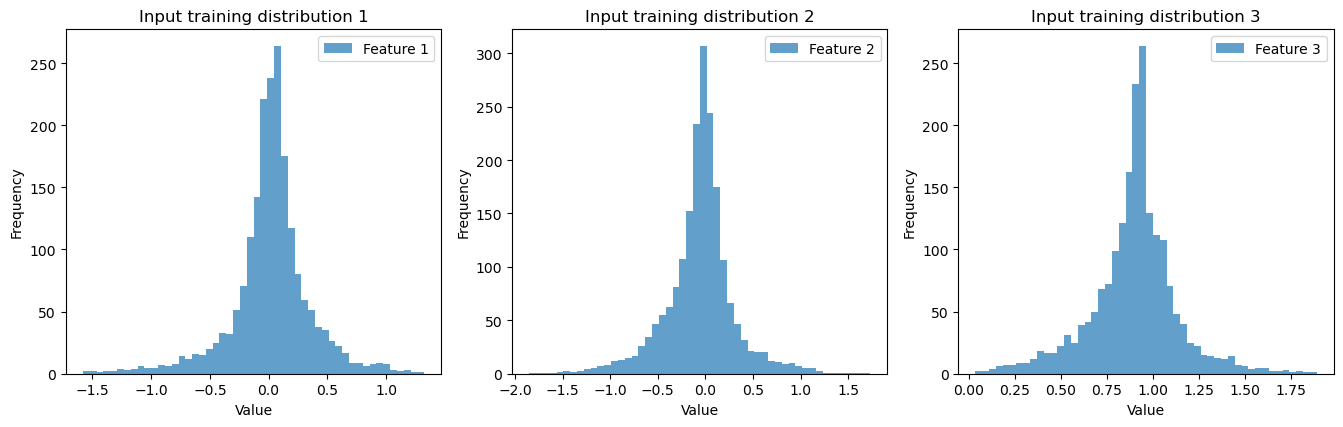

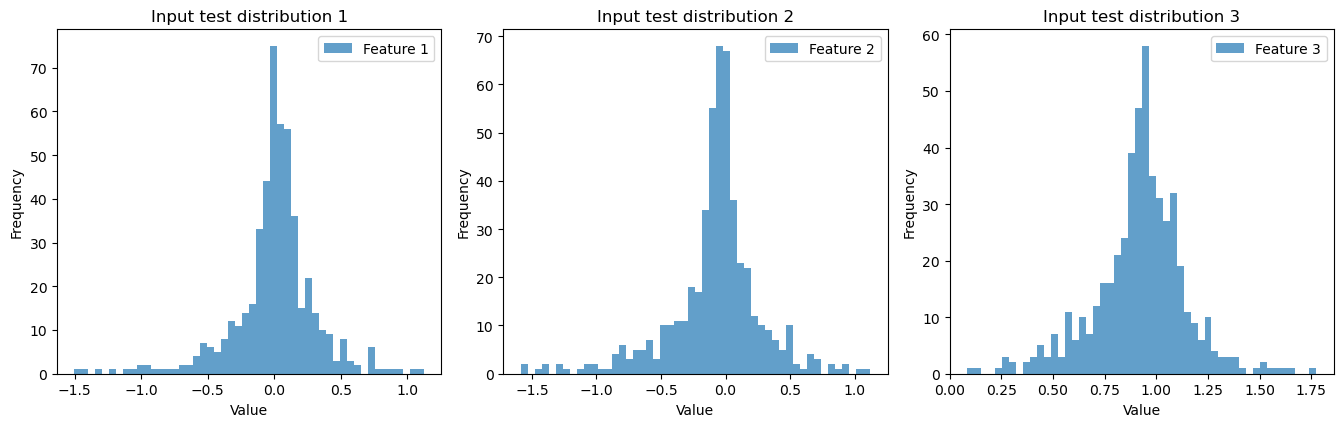

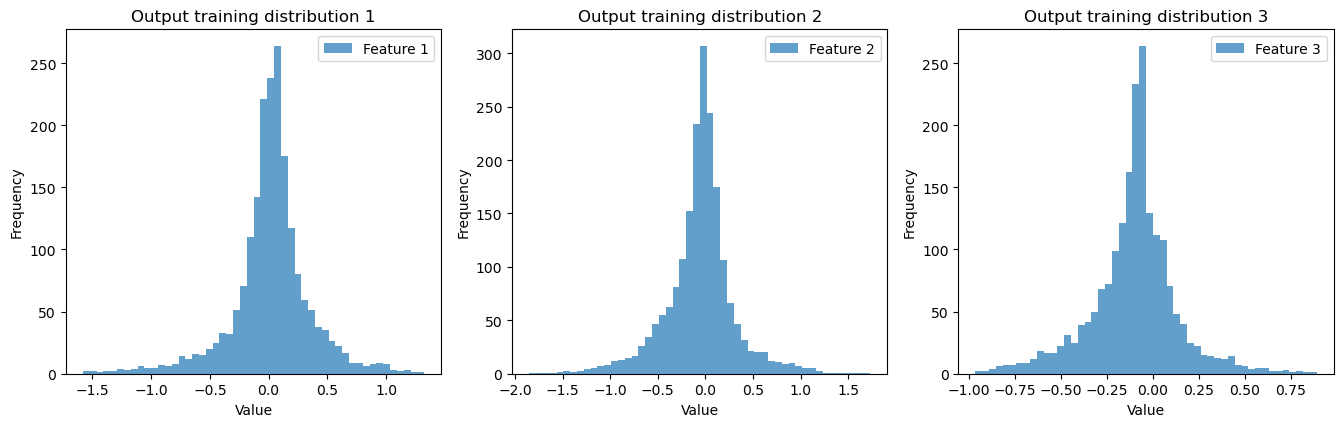

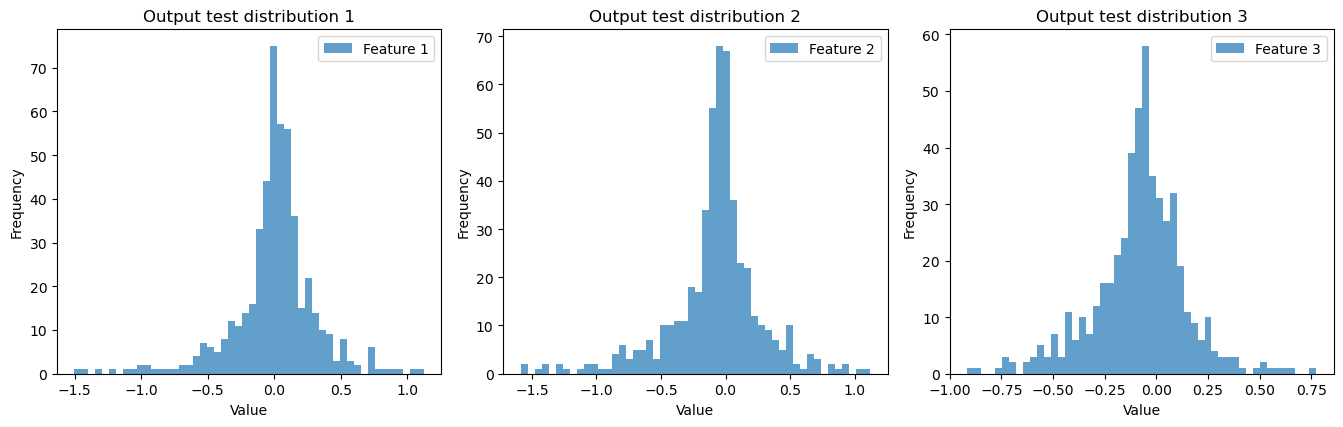

In [18]:

features_hist(X_train, 'Input training distribution', 'Value', 'Frequency')
features_hist(X_test, 'Input test distribution', 'Value', 'Frequency')
features_hist(y_train, 'Output training distribution', 'Value', 'Frequency')
features_hist(y_test, 'Output test distribution', 'Value', 'Frequency')

In [19]:
# print min and max values of the input and output data
print("Min value of input data:", X_train.min())
print("Max value of input data:", X_train.max())
print("Min value of output data:", y_train.min())
print("Max value of output data:", y_train.max())

Min value of input data: -1.850081580823225
Max value of input data: 1.891514507843733
Min value of output data: -1.8500815825220998
Max value of output data: 1.731677117405425


### Model building

In [20]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

# Build the model
model = Sequential()
model.add(Input(shape=(3,)))  # Input layer

model.add(Dense(128, activation='relu'))  # Hidden layer
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dense(64, activation='relu'))  # Hidden layer

model.add(Dense(3))  # Output layer

2024-07-23 10:35:00.630844: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 10:35:00.832888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 10:35:00.956018: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 10:35:00.988231: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-23 10:35:01.155195: I tensorflow/core/platform/cpu_feature_guar

### Train model

In [21]:
# Training the model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Accuracy, RootMeanSquaredError

# Define the RMSE loss function
def rmse_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

model.compile(optimizer='adam',
                loss=MeanSquaredError(), 
                metrics=[RootMeanSquaredError()])
                
history = model.fit(X_train, 
          y_train,
          epochs=50, 
          batch_size=64, 
          validation_split=0.2)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0842 - root_mean_squared_error: 0.2887 - val_loss: 0.0270 - val_root_mean_squared_error: 0.1644
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0177 - root_mean_squared_error: 0.1328 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1000
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - root_mean_squared_error: 0.0864 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - root_mean_squared_error: 0.0473 - val_loss: 7.1901e-04 - val_root_mean_squared_error: 0.0268
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4434e-04 - root_mean_squared_error: 0.0233 - val_loss: 3.3664e-04 - val_root_mean_squared_error: 0.0183
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0507e-04 - root_mean_squared_error: 0.0143 - val_loss: 2.0469e-04 - val_root_mean_squared_error: 0.0143
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7

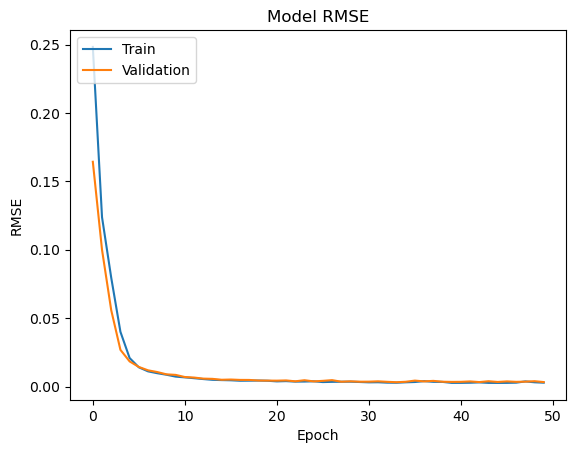

In [22]:
# Plot training and validation root mean squared error
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

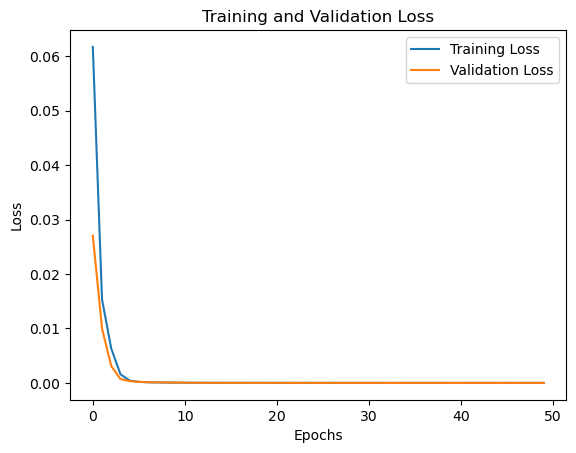

In [23]:
# Plot the training loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Validate the model

In [24]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9133e-06 - root_mean_squared_error: 0.0022 
Loss: 5.255516043689568e-06


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


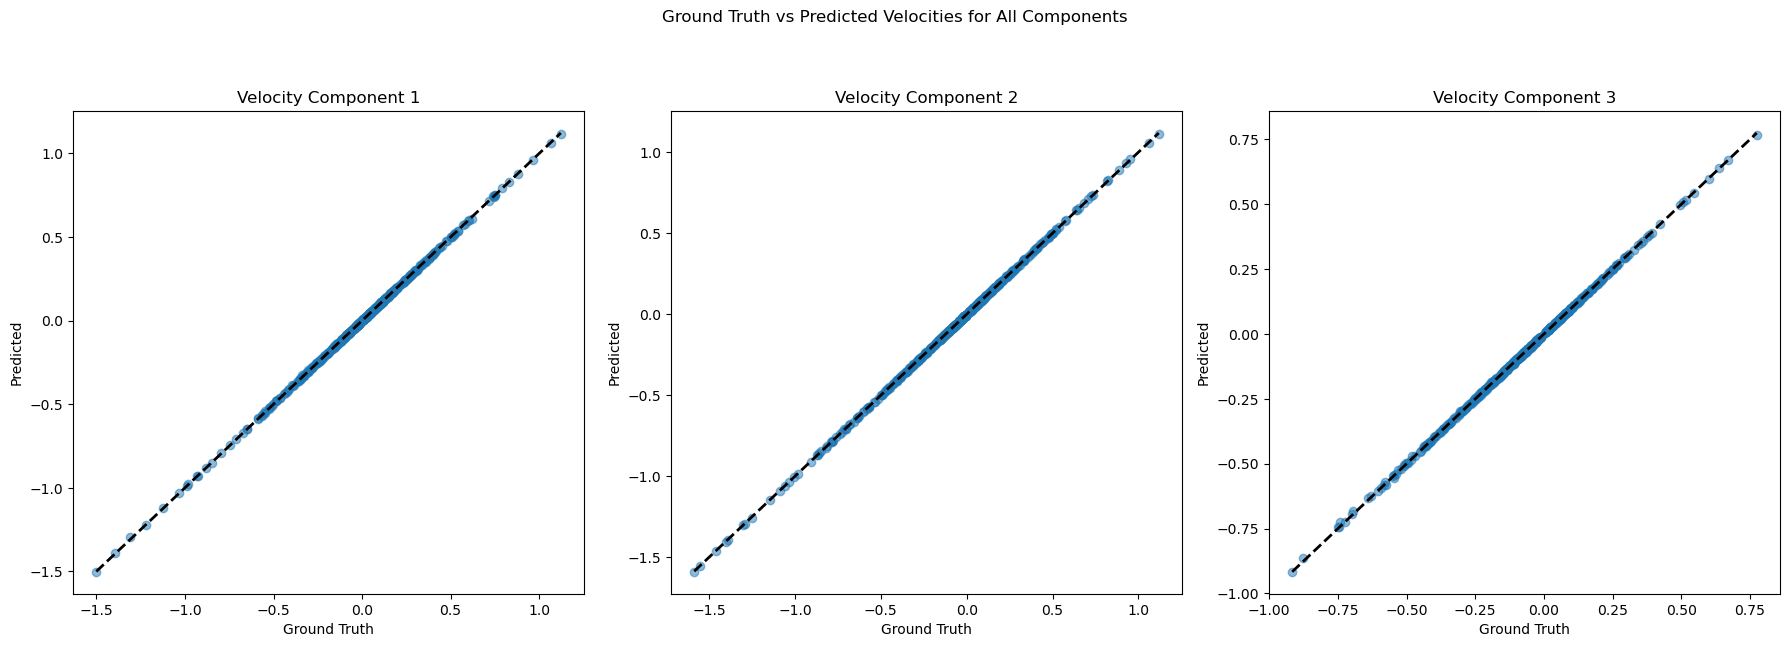

In [25]:
# Make one plot for each of the  velocity components
y_pred = model.predict(X_test)

# Initialize a figure for a 2x3 grid of subplots
plt.figure(figsize=(18, 12))

for i in range(3):
    # Create subplot in a 2x3 grid
    plt.subplot(2, 3, i+1)
    # Plot the predicted and ground truth velocities
    plt.scatter(y_test[:, i], y_pred[:, i], alpha=0.5)
    plt.plot([y_test[:, i].min(), y_test[:, i].max()], [y_test[:, i].min(), y_test[:, i].max()], 'k--', lw=2)  # Add a line of y=x for reference
    plt.xlabel('Ground Truth')
    plt.ylabel('Predicted')
    plt.title(f'Velocity Component {i+1}')

plt.suptitle('Ground Truth vs Predicted Velocities for All Components')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.show()

### Save model

In [26]:
# Save model
model.save('models/uv_pstar.keras')